# Look into Tau TSPS

I explore using tau and TSPS to calculate a gene level tissue specificity score.

In [129]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from IPython.display import Markdown, HTML, display

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from goatools.obo_parser import GODag
from goatools import GOEnrichmentStudy
from goatools.mapslim import mapslim

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb

# Setup notebook
nbconfig = Nb.setup_notebook('2018-02-05_tau', table_dir='../output')

last updated: 2018-02-07 
Git hash: be8ef9727c59afa8d3497e24ff289ad4e61e8c95


In [7]:
# functions to calculate tau and tsps. Assumes a series of genes
def tau(x):
    _max = x.max()
    if _max == 0:
        return np.nan
    _n = x.shape[0]
    xhat = x / _max
    tau = (1 - xhat).sum() / (_n - 1)
    return tau

def tsps(x):
    from scipy.stats import entropy
    if x.sum() == 0:
        return np.nan
    _n = x.shape[0]
    _q = np.array([1 / _n, ] * _n)
    return entropy(x, _q, 2)

## Haiwang Data

First I use tissue data from Haiwang's project. He has 8 tissues, males/females, and two strains (w1118/oreR).

In [5]:
!cat ../data/external/haiwang/README

This data was provided by Haiwang on February 2, 2018. It consists of a
normalized counts matrix for D. melanogaster (w1118 and oreR). With the
following body parts:

ac --- abdomen carcass
dg --- digestive system
ge --- genitalia or terminalia
go --- gonad
hd --- head.
re --- reproductive tract
tx --- thorax
wb --- whole body.

This data is for use in calculating tau and TSPS.


In [6]:
# Import data and melt
dat = pd.read_csv('../data/external/haiwang/dmel.genic.nrc.txt', sep='\t')
dat.index.name = 'FBgn'

melted = dat.reset_index().melt(id_vars='FBgn', var_name='sample')

# Create metadata based on sample names
melted['strain'] = melted['sample'].map(lambda x: x.split('_')[0])
melted['sex'] = melted['sample'].map(lambda x: x.split('_')[1])
melted['tissue'] = melted['sample'].map(lambda x: x.split('_')[2])
melted['rep'] = melted['sample'].map(lambda x: x.split('_')[3])

# Calculate median across replicates
cleaned = melted.groupby(['FBgn', 'sex', 'tissue'])['value'].median().to_frame().unstack()

## tau

In [8]:
# Calculate tau for each sex
taus = cleaned.apply(tau, axis=1).to_frame()
taus.columns = ['tau', ]

male_tau = taus.loc[(slice(None), 'm'), :]
female_tau = taus.loc[(slice(None), 'f'), :]

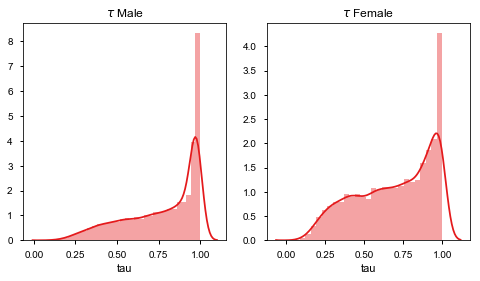

In [9]:
# Plot
def _plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(.5)) 
    sns.distplot(male_tau['tau'].dropna(), ax=ax1)
    ax1.set_title(r'$\tau$ Male')
    sns.distplot(female_tau['tau'].dropna(), ax=ax2)
    ax2.set_title(r'$\tau$ Female')

_plot()

In [11]:
male_tau.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('male_tau.tsv'), sep='\t')
female_tau.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('female_tau.tsv'), sep='\t')

## TSPS 

In [13]:
tspss = cleaned.apply(tsps, axis=1).to_frame()
tspss.columns = ['tsps', ]
male_tsps = tspss.loc[(slice(None), 'm'), :]
female_tsps = tspss.loc[(slice(None), 'f'), :]

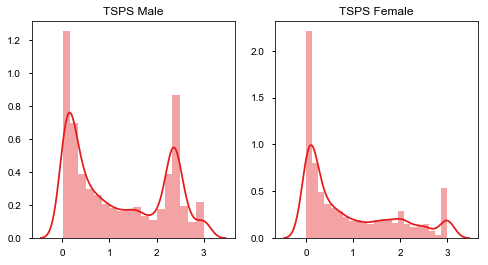

In [14]:
def _plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(.5))
    sns.distplot(male_tsps.dropna(), ax=ax1)
    ax1.set_title('TSPS Male')
    sns.distplot(female_tsps.dropna(), ax=ax2)
    ax2.set_title('TSPS Female')
    
_plot()

In [15]:
male_tsps.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('male_tsps.tsv'), sep='\t')
female_tsps.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('female_tsps.tsv'), sep='\t')

## modENCODE

I also grabbed what modENCODE RNA-seq data I have processed from the SRA project. The metadata is problematic for the modENCODE data in SRA, so I had to use data pulled from modMINE. For a quick and dirty meature I just used all cell line, developmental stages, and tissues to calculate the metrics.

In [43]:
# Munge
cnts = pd.read_csv('../data/external/sra_modENCODE.tsv', sep='\t', comment='#', index_col=0)
metadata = pd.read_csv('../data/external/sra_modENCODE_metadata.tsv', sep='\t', comment='#', index_col=0).fillna('')
dat = cnts.T.join(metadata).groupby(['cell_line', 'developmental_stage', 'strain', 'tissue']).median().T
dat.columns = list(range(len(dat.columns)))

In [56]:
# Calculate tau and tsps
tauDat = dat.apply(tau, axis=1)
tspsDat = dat.apply(tsps, axis=1)

Text(0.5,1,'TSPS')

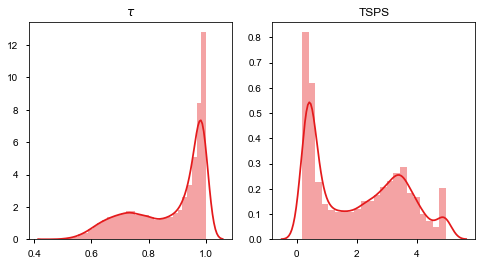

In [58]:
# plot them
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(.5))
sns.distplot(tauDat.dropna(), ax=ax1)
ax1.set_title(r'$\tau$')
sns.distplot(tspsDat.dropna(), ax=ax2)
ax2.set_title('TSPS')

## Compare Haiwang and modENCODE

In [136]:
# munge
hTau = male_tau.reset_index().drop('sex', axis=1).set_index('FBgn').tau
cmb = pd.concat([hTau, tauDat], axis=1).dropna()

# spearman r
stat, pval = spearmanr(cmb.iloc[:, 0], cmb.iloc[:, 1])
tau = r'$\tau$'

Markdown(f"""
Next I want to compare Haiwang's and modENCODE's {tau}/TSPS to see if they give similar results. 
The easiest way to look at this is to use rank correlations. 
First I looked at {tau} using Spearman r. 
I found a correlation of {np.round(stat, 2)}, which was significant (p≤{pval}).
This suggests that {tau} of genes tends to be similar between the two datasets.
""")


Next I want to compare Haiwang's and modENCODE's $\tau$/TSPS to see if they give similar results. 
The easiest way to look at this is to use rank correlations. 
First I looked at $\tau$ using Spearman r. 
I found a correlation of 0.74, which was significant (p≤0.0).
This suggests that $\tau$ of genes tends to be similar between the two datasets.


In [142]:
# munge
hTSPS = male_tsps.reset_index().drop('sex', axis=1).set_index('FBgn').tsps
cmb = pd.concat([hTSPS, tspsDat], axis=1).dropna()

# spearman r
stat, pval = spearmanr(cmb.iloc[:, 0], cmb.iloc[:, 1])
tau = r'$\tau$'

Markdown(f"""
Next I looked at TSPS using the same spearman r metric.
I found a correlation of {np.round(stat, 2)}, which was significant (p≤{pval}).
It looks like TSPS behaves more similar betwee datasets than {tau}.
""")


Next I looked at TSPS using the same spearman r metric.
I found a correlation of 0.8, which was significant (p≤0.0).
It looks like TSPS behaves more similar betwee datasets than $\tau$.


## GO Enrichment

In [2]:
# import GO dags
obodag = GODag("../data/external/go-basic.obo")
slimdag = GODag("../data/external/goslim_generic.obo")

load obo file ../data/external/go-basic.obo
../data/external/go-basic.obo: fmt(1.2) rel(2018-02-02) 47,109 GO Terms
load obo file ../data/external/goslim_generic.obo
../data/external/goslim_generic.obo: fmt(1.2) rel(None) 228 GO Terms


In [3]:
# Import fly associations
fly = defaultdict(set)
with open('../data/external/gene_association.fb') as fh:
    for row in fh.readlines():
        if row.startswith('!'):
            continue
        cols = row.split('\t')
        fbgn = cols[1]
        goterm = cols[4]
        gtype = cols[11]
        if gtype != 'protein':
            continue
        if goterm not in obodag:
            continue
        fly[fbgn].add(goterm)

In [4]:
# map them to a slim set
flyslim = defaultdict(set)
for fbgn, goterms in fly.items():
    all_direct_anc = set()
    all_covered_anc = set()
    all_all_anc = set()
    for goterm in goterms:
        direct_anc, all_anc = mapslim(goterm, obodag, slimdag)
        all_all_anc |= all_anc
        # collect all covered ancestors, so the direct ancestors
        # can be calculated afterwards
        all_covered_anc |= (all_anc - direct_anc)
    all_direct_anc = all_all_anc - all_covered_anc
    flyslim[fbgn] |= (all_direct_anc)

In [10]:
# bg = male_tau.dropna().index.get_level_values(0).tolist()
# 
# goeaobj = GOEnrichmentStudy(
#         bg, # Background 
#         flyslim, # geneid/GO associations
#         slimdag, # Ontologies
#         propagate_counts = False,
#         alpha = 0.001, # default significance cut-off
#         methods = ['fdr_bh']) # defult multipletest correction method
# 
# bins = pd.qcut(male_tau.dropna().tau, 20).reset_index().set_index('tau')['FBgn']
# groups = {}
# for g, d in bins.to_frame().groupby(level=0):
#     try:
#         groups[g] = [r.name for r in goeaobj.run_study(d.FBgn.values.tolist(), log=None) if r.p_fdr_bh <= 0.001]
#     except ZeroDivisionError:
#         print(d)